In [281]:
import numpy as np
from collections import Counter
def stochastic_round(x):
    x = np.asarray(x)
    floor_x = np.floor(x)
    prob = x - floor_x
    return floor_x + (np.random.rand(*x.shape) < prob)
# 市场收入计算。amount为正时购买商品，输出所消耗货币量
def trader(product_eff, storage, balance, amount, shift = 0, r = 0.2, inflation = 1):
    base = (r + shift) * balance + storage
    return np.round(inflation / product_eff * (1+r) * balance * (np.log(base+amount) - np.log(base)),3)
#     return np.round(balance *  amount/ base/product_eff, 3)
class ability:
    def __init__(self, consumption, product_eff, pop, status, wealth):
        self.consumption = np.array(consumption, dtype=float)
        self.product_eff = np.array(product_eff, dtype=float)
class TradeBlock(ability):
    def __init__(self, consumption, pop, product_eff, status, wealth):
        """
        经济模拟系统中的有贸易区块类。
        """
        # 读取参数，状态和工作时间
        super().__init__(consumption, product_eff, pop, status, wealth)
        self.pop = np.array(pop, dtype=float) # 集体的库存
        self.status = np.array(status, dtype=float) # 集体的库存
        self.wealth = np.array(wealth, dtype=float) # 各职业手中的货币
        
        self.n = len(self.pop)
        self.status_hist = []
        self.last_diff = 0.001
        self.pop_last = self.pop+0
    def evol_Produce(self):
        """
        经济演化过程的生产与统一收购

        """
        
        # 仓储均衡位置
        self.balance = 10 * sum(self.pop) * self.product_eff[1:]
        # 计算表观价格
        self.prices = 1.1 / (self.status[1:] / self.balance + .1)
        self.prices = np.insert(self.prices, 0, 1.0)
        # 计算各职业储蓄目标
        self.save_aim = np.round(10 * (self.consumption * self.prices).sum(axis = 1),3)

        # 计算各职业每日工作时长 #
        # 个人财富= 总财富 / 相应阶级人口
        pop_div = self.pop + 0
        pop_div[pop_div<1]=1
        self.per_wealth = self.wealth / pop_div
        # 满意度 = 个人财富 / 储蓄目标 （满意度为 1 时开始不再全天工作）
        self.satisfy = self.per_wealth / self.save_aim
        # 工作时长 = exp(1 - 满意度)，且上限为1
        self.worktime = np.exp((1 - self.satisfy))
        self.worktime[self.worktime > 1] = 1
        self.worktime = np.round(self.worktime,2)

        # 计算各职业每日生产量 = 工作时长 × 生产效率
        self.production = self.pop * np.round(self.worktime * self.product_eff,2)
    def evol_Levy(self):
        """
        经济演化过程收购

        """
        # 出售所得货币量 = 生产量 × 产品价格
        self.sold_value = trader(self.product_eff[1:], self.status[1:], self.balance, self.production[1:])
#         print("detail",self.product_eff[1:],self.balance, self.status[1:], self.production[1:],self.sold_value,"end")
        # (待出售的)新状态 = 旧状态 + 产量
        self.sold_prices = self.sold_value / (self.production[1:] + 0.001)
        self.sold_prices = np.insert(self.sold_prices, 0, 1.0)
        self.status[1:] = self.status[1:] + self.production[1:]

        # 计算各职业新的财富状态 #
        # 所有商品（不包括货币）统一进入仓库，并结算货款（可贷款）
        self.status[0] = self.status[0] - sum(self.sold_value)
        self.wealth[1:] += self.sold_value
        # 货币直接进入财富
        self.wealth[0] += self.production[0]
    def evol_Consume(self):
        """
        经济演化过程的本地销售与消费

        """
        for j in range(self.n): # 从第 j 种商品开始依次购买
            for i in range(self.n): # 从第 i 个阶级开始依次购买
                new_status = self.status[j] - self.consumption[i,j] * self.pop[i]
                if j == 0:
                    # 判断财富是否足以上税
                    new_wealth =  self.wealth[i] - self.consumption[i,j] * self.pop[i]
                else:
                    # 判断财富是否足以购买商品（此时商品减少，trader（市场收入）为负）
                    trade_value = trader(self.product_eff[j],  self.status[j], self.balance[j-1], -self.consumption[i,j] * self.pop[i])
#                     self.sold_value = trader(self.product_eff[1:], self.status[1:], self.balance, self.production[1:])
                    new_wealth = self.wealth[i] + trade_value
#                 if i < 5:
#                     print("test",i,j,new_status,new_wealth, self.wealth[i],self.status[j],self.pop[i])
#                 print(new_status,self.wealth[i], self.consumption[i,j] * self.pop[i],new_wealth)
                if new_status > 0 and (new_wealth > 0): 
                # 如果库存足够消费，且该阶级存款足够/是统治阶级，则进行交易
                    self.status[j] = new_status
                    self.wealth[i] = new_wealth
                    self.status[0] -= trade_value
                    if j == 0:
                        # 上税时回收货币到统治阶级手中
                        self.status[0] += self.consumption[i,j] * self.prices[j]
    def evol_Adjust(self):
        """
        经济演化后根据库存量调整商品价格，并处理转职

        """
        # 单位时间生产效率 = 商品价格 * 产品生产效率
        self.eff = self.sold_prices * self.product_eff
        # 不同职业间的效率差额
        self.diff = (self.eff[:, None] - self.eff[None, :])/self.eff
        self.diff = np.arctan(self.diff) / np.pi
        # 只取出走者部分，入职部分 后续会通过 转置相减(反对称化) 得到
        self.diff[self.diff < 0] = 0
        # 出走人数 正比于 出走职业人数
#         self.diff = 50*((self.diff * (self.pop-1) * np.exp(1 - self.pop_last / self.pop) / sum(self.pop)).T).T  
        self.diff = 0.5*((self.diff * (self.pop)).T).T  
        self.diff -= .1 * self.last_diff
        self.last_diff = self.diff + 0
        self.diff = stochastic_round(self.diff)
        r = 0.01 
#         self.pop_last = self.pop * r + self.pop_last * (1-r)
#         print(self.diff)
        # 出走者的财富 即 该阶级的 人均财富
        self.dif_wealth = self.diff * self.per_wealth
        self.dif_wealth -= self.dif_wealth.T
        self.wealth -= self.dif_wealth.sum(axis = 0)
        # 转置相减(反对称化)
        self.diff -= self.diff.T
        self.pop -= self.diff.sum(axis = 0)
        # 计算库存目标(货币不计) = 各项消耗 × 对应阶级人口 并对各阶级求和得到某项商品总消耗
        self.product_aim = 10 * (self.consumption.T * self.pop).sum(axis = 1)[1:]
        # 计算爆仓焦虑 = （库存 - 库存期望）/（库存 + 库存期望）
        self.urg_storage = (self.status[1:] - self.product_aim) / (self.status[1:] + self.product_aim)
        # 计算供需焦虑 =（生产量 - 预估消耗量）/（生产量 + 预估消耗量）
        self.est = (self.consumption.T * self.pop).sum(axis = 1)
        self.urg_supply = (self.production - self.est + 0.001) / (self.est + self.production + 0.001)
        # 计算新价格 = 原价格 × exp(爆仓焦虑+供需焦虑)
        self.prices[1:] = self.prices[1:] * np.exp(- .2 * self.urg_storage - 0.2 * self.urg_supply[1:])
        # 根据货币供给(市场当前货币量)进行补偿调整，防止价格同步上涨获取货币收益过低
        self.prices[1:] = np.round(self.prices[1:] * np.exp(0 * self.status[0] / sum(self.pop)),3)
        self.prices[self.prices > 100] = 100
        self.prices[self.prices < .01] = .01
    def recorder(self, show):
        if show != 0:
            print("status",self.status)
            print("prices",self.prices)
            print("eff",self.eff)
            print("wealth",self.wealth)
            print("pop",self.pop)
            print("pre_wealth",self.per_wealth)
            print("work_time",self.worktime)
            print("save_aim",self.save_aim)
            print("product_aim",self.product_aim)
    def evolution(self, show):
        self.evol_Produce()
        self.evol_Levy()
        self.evol_Consume()
        self.evol_Adjust()
        self.recorder(show)
        
test = TradeBlock(
    [[0,1,1],[0,1,1],[0,1,1]],#consumption
    [20,200,80],#pop
    [1,2,5],#product_eff
    [0,0,0],#status(storage)
    # [1,.5,.2],#prices
    [0, 0, 0])#wealth

In [286]:
pop = []
prices = []
wealth = []
for i in range(1000):
    test.evolution(0)
    pop.append(test.pop+0)
    prices.append(test.sold_prices+0)
    wealth.append(test.wealth+0)
#     print(test.pop,test.prices,np.round(test.per_wealth,3))
#     print(test.save_aim, test.status, test.product_aim, test.worktime)

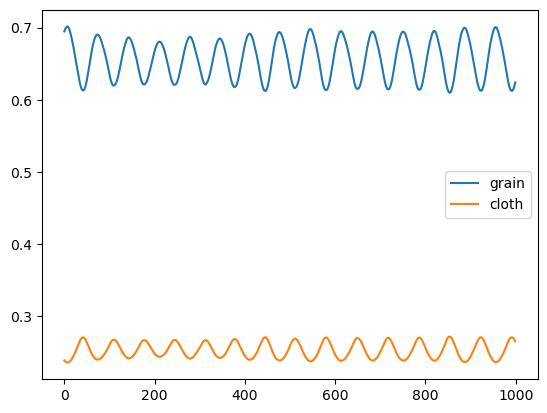

In [287]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
v = prices
indices = np.linspace(0, len(v)-1, 500, dtype=int)
plt.plot(indices,np.array(v)[indices,1],label = "grain")
plt.plot(indices,np.array(v)[indices,2],label = "cloth")
plt.legend()

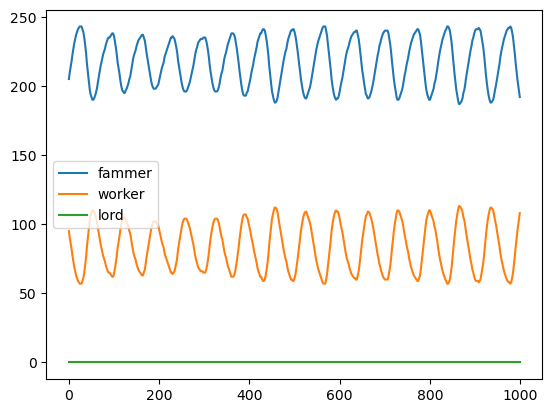

In [288]:
v = pop
indices = np.linspace(0, len(v)-1, 500, dtype=int)
plt.plot(indices,np.array(v)[indices,1],label="fammer")
plt.plot(indices,np.array(v)[indices,2],label="worker")
plt.plot(indices,np.array(v)[indices,0],label="lord")
plt.legend()

In [291]:
v = wealth
indices = np.linspace(0, len(v)-1, 500, dtype=int)
plt.plot(indices,np.array(v)[indices,1]/(.1+np.array(pop)[indices,1]),label="fammer")
plt.plot(indices,np.array(v)[indices,2]/(.1+pop[indices,2]),label="worker")
plt.plot(indices,np.array(v)[indices,0]/(.1+pop[indices,0]),label="lord")
plt.legend()

TypeError: list indices must be integers or slices, not tuple

In [149]:
test.status

array([-2126.701,   208.04 ,  1615.3  ])

In [ ]:
(np.array([1,2])) * np.array([[1,2],[3,4]])

In [ ]:
np.array([[1,2],[3,4]]).sum(axis = 1)

In [ ]:
test.wealth

In [ ]:
test.status

In [ ]:
test.pop

In [ ]:
test.eff

In [ ]:
test.product_aim

In [ ]:
test.consumption

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def visual(block):
    fig = plt.figure(figsize=(11, 7))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1.2, 1])  # 上1行，下1行，比例2:1
    plt.plot()
visual(1)

In [ ]:
a = np.array([[1,1],[0,1]]) * np.array([[1.2,-2.5],[3,4]])
a[a>3] = 5
a/np.array([5,10])

In [ ]:
a

In [ ]:
def stochastic_round(x):
    x = np.asarray(x)
    floor_x = np.floor(x)
    prob = x - floor_x
    return floor_x + (np.random.rand(*x.shape) < prob)
stochastic_round([2.4,3.9])

In [ ]:
import numpy as np

A = np.array([
    [1, 2, 3],
    [4, 5, 6]
])

L = A.tolist()

print(L)


In [ ]:
a = []
a.append((np.array([[1,2],[3,4]])).tolist())
a

In [ ]:
test.wealth / test.pop

In [ ]:
test.save_aim

In [ ]:
test.worktime

In [ ]:
test.satisfy

In [ ]:
test.pop

In [ ]:
test.daily_consumption

In [ ]:
test.daily_cost

In [ ]:
test.soldvalue

In [ ]:
test.production

In [ ]:
test.wealth

In [ ]:
test.product_aim

In [ ]:
test.per_wealth